In [260]:
import pandas as pd
import numpy as np
import seaborn as sns
from pyspark.sql import SparkSession

# instantiate SparkSession object
# spark = SparkSession.builder.master('local').getOrCreate()

spark = SparkSession\
        .builder\
        .appName('ALSExample').config('spark.driver.host', 'localhost')\
        .getOrCreate()

In [328]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
import pyspark as spark
spark = SparkSession.builder.appName('Recommendation_system').getOrCreate()
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [332]:
reviews = pd.read_csv('../../data/raw/ratings.csv')
links = pd.read_csv('../../data/raw/links.csv')
movies = pd.read_csv('../../data/raw/movies.csv')
tags = pd.read_csv('../../data/raw/tags.csv')

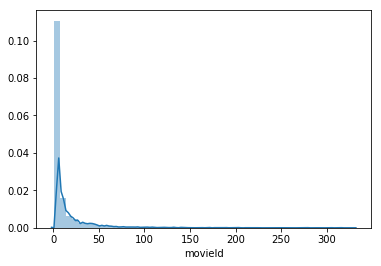

In [333]:
sns.distplot(reviews.movieId.value_counts());

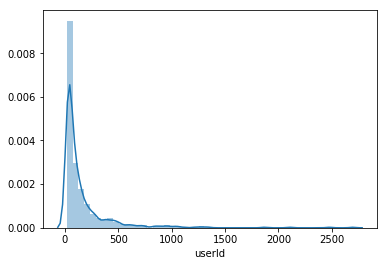

In [334]:
sns.distplot(reviews.userId.value_counts());

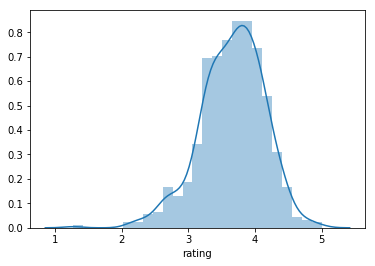

In [335]:
sns.distplot(reviews.groupby('userId')['rating'].mean());

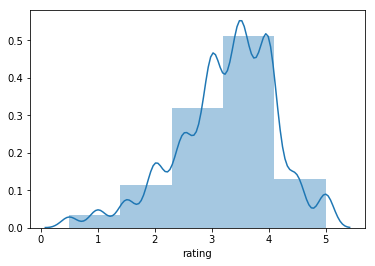

In [336]:
sns.distplot(reviews.groupby('movieId')['rating'].mean(),bins=5);

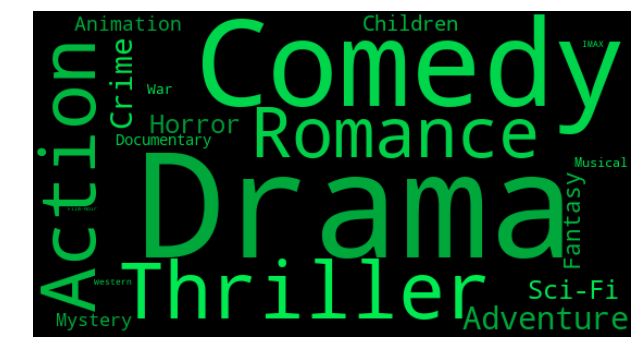

In [337]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue
        for s in liste_keywords: 
            if pd.notnull(s): keyword_count[s] += 1
    # convert the dictionary in a list to sort the keywords  by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Function that control the color of the words
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)


#Finally, the result is shown as a wordcloud:
words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='black', 
                      max_words=1628,relative_scaling=0.7,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

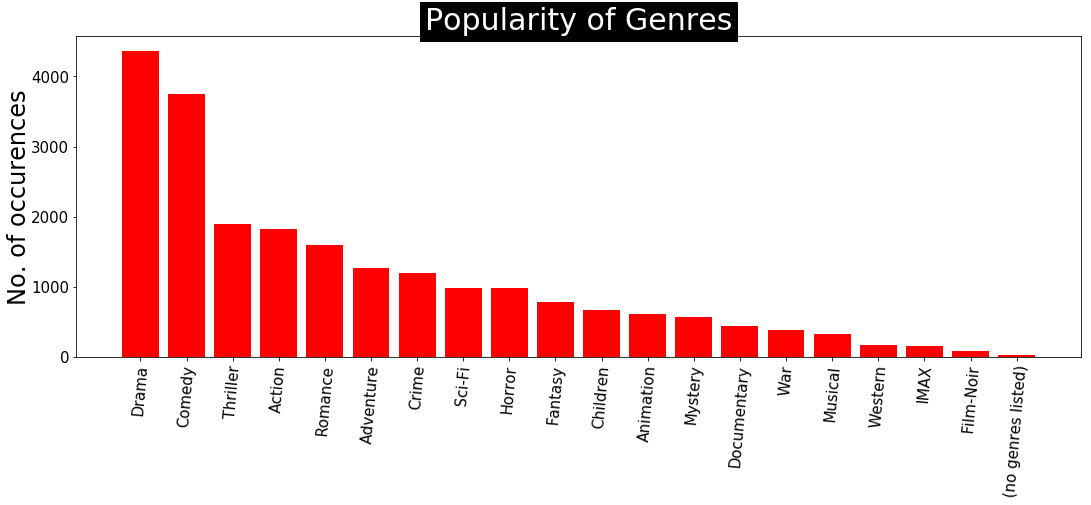

In [338]:
# lets display the same result in the histogram
fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("No. of occurences", fontsize = 24, labelpad = 0)
ax2.bar(x_axis, y_axis, align = 'center', color='r')
plt.title("Popularity of Genres",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 30)
plt.show()

In [29]:
# movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))

# Spark ALS Model

In [30]:
movie_ratings = spark.read.csv('../../data/raw/ratings.csv', header='true', inferSchema='true')
movie_ratings = movie_ratings.drop('timestamp')

In [31]:
# split into training and testing sets
(training, test) = movie_ratings.randomSplit([0.8, 0.2])

# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5,rank=4, regParam=0.01, userCol='userId', itemCol='movieId', ratingCol='rating',
          coldStartStrategy='drop')

# fit the ALS model to the training set
model = als.fit(training)

In [32]:
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating',
                                predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print('Root-mean-square error = ' + str(rmse))

Root-mean-square error = 0.9838868536667542


In [263]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [34]:
# initialize the ALS model
als_model = ALS(userCol='userId', itemCol='movieId', 
                ratingCol='rating', coldStartStrategy='drop')

# create the parameter grid                 
params = ParamGridBuilder()\
          .addGrid(als_model.regParam, [0.01, 0.001, 0.1])\
          .addGrid(als_model.rank, [4, 10, 50]).build()


# instantiating crossvalidator estimator
cv = CrossValidator(estimator=als_model, estimatorParamMaps=params,evaluator=evaluator,parallelism=4)
best_model = cv.fit(movie_ratings)    

# We see the best model has a rank of 50, so we will use that in our future models with this dataset
best_model.bestModel.rank

4

In [264]:
def new_user_recs(user_id, new_ratings, rating_df, movie_title_df, num_recs):
    # turn the new_recommendations list into a spark DataFrame
    movie_id_list = []
    new_user_ratings = spark.createDataFrame(new_ratings,rating_df.columns)
    
    # combine the new ratings df with the rating_df
    movie_ratings_combined = rating_df.union(new_user_ratings)
    
    # split the dataframe into a train and test set
#     (training, test) = movie_ratings_combined.randomSplit([0.8, 0.2],seed=0)
    
    # create an ALS model and fit it
    als = ALS(maxIter=5, rank=50, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
    model = als.fit(movie_ratings_combined)
    
    # make recommendations for all users using the recommendForAllUsers method
    recommendations = model.recommendForAllUsers(num_recs)
    
    # get recommendations specifically for the new user that has been added to the DataFrame
    recs_for_user = recommendations.where(recommendations.userId == user_id).take(1)
    
    for ranking, (movie_id, rating) in enumerate(recs_for_user[0]['recommendations']):
        movie_string = name_retriever(movie_id, movie_title_df)
        movie_id_list.append(movie_id)
        print(movie_id)
        print('Recommendation {}: {}  | predicted score :{}'.format(ranking+1, movie_string, rating))
        
    return movie_id_list

In [265]:
def name_retriever(movie_id, movie_title_df):
    return movie_title_df.where(movie_title_df.movieId == movie_id).take(1)[0]['title']

In [129]:
movie_titles = spark.read.csv('../../data/raw/movies.csv', header='true', inferSchema='true')

In [266]:
# try out your function with the movies listed above
user_id = 1000
user_ratings_1 = [(user_id,3257,5),
                  (user_id,2459,1),
                  (user_id,2513,2),
                  (user_id,6502,2),
                  (user_id,1091,2),
                  (user_id,441,4)]
new_user_recs(user_id,
             new_ratings=user_ratings_1,
             rating_df=movie_ratings,
             movie_title_df = movie_titles ,
             num_recs = 5)

3257
Recommendation 1: Bodyguard, The (1992)  | predicted score :4.987771034240723
62
Recommendation 2: Mr. Holland's Opus (1995)  | predicted score :4.504103660583496
364
Recommendation 3: Lion King, The (1994)  | predicted score :4.409041404724121
6942
Recommendation 4: Love Actually (2003)  | predicted score :4.313936233520508
356
Recommendation 5: Forrest Gump (1994)  | predicted score :4.218995571136475


[3257, 62, 364, 6942, 356]

# Making movie content filtering system

In [267]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

In [268]:
movies = pd.read_csv('../../data/raw/movies.csv')

In [269]:
movies['year'] = movies['title'].apply(lambda x: x[-5:-1].strip('('))
movies['year'] = movies['year'].apply(lambda x: x.strip(')'))
movies['year'] = movies['year'].apply(lambda x: x.strip('-'))
movies = movies.drop(movies[movies['title'].str.contains("\(") == False].index)
movies['genres'] = movies.genres.str.split("|")

In [270]:
movies

,movieId,title,genres,year
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II (1995),[Comedy],1995
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]",2017
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]",2017
9739,193585,Flint (2017),[Drama],2017
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]",2018


In [ ]:
## how do we deal with these??
genre_reviews.loc[genre_reviews['(no genres listed)'] == True]

In [271]:
tags = pd.read_csv('../../data/raw/tags.csv')

In [272]:
tags['joined_tags'] = tags.groupby('movieId')['tag'].transform(lambda x: ' '.join(x))

In [273]:
tags = tags[['movieId', 'joined_tags']].drop_duplicates()

In [274]:
tags

,movieId,joined_tags
0,60756,funny Highly quotable will ferrell comedy funn...
3,89774,Boxing story MMA Tom Hardy
6,106782,drugs Leonardo DiCaprio Martin Scorsese Stock ...
9,48516,way too long Leonardo DiCaprio suspense twist ...
10,431,Al Pacino gangster mafia
...,...,...
3674,1948,British
3676,5694,70mm
3677,6107,World War II
3679,7936,austere


In [51]:
tags.loc[tags.movieId == 1]

,movieId,joined_tags
629,1,pixar pixar fun


In [73]:
# avg_review = pd.DataFrame(reviews.groupby('movieId')['rating'].mean())

In [78]:
# avg_review['no_of_ratings'] = reviews.groupby('movieId')['rating'].count()

In [69]:
# movies_ratings = genre_reviews.merge(avg_review, how = 'inner', on = 'movieId')

# NLTK

In [275]:
from nltk import *
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from rake_nltk import Rake

In [276]:
movies

,movieId,title,genres,year
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II (1995),[Comedy],1995
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]",2017
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]",2017
9739,193585,Flint (2017),[Drama],2017
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]",2018


In [277]:
tags

,movieId,joined_tags
0,60756,funny Highly quotable will ferrell comedy funn...
3,89774,Boxing story MMA Tom Hardy
6,106782,drugs Leonardo DiCaprio Martin Scorsese Stock ...
9,48516,way too long Leonardo DiCaprio suspense twist ...
10,431,Al Pacino gangster mafia
...,...,...
3674,1948,British
3676,5694,70mm
3677,6107,World War II
3679,7936,austere


In [282]:
movies_w_tags = movies.merge(tags, on='movieId')

In [284]:
movies_w_tags['genres'] = movies_w_tags['genres'].apply(lambda x: ' '.join([str(elem) for elem in x]) )

In [286]:
movies_w_tags['joined_tags'] = movies_w_tags['joined_tags'].apply(lambda x: x.replace(',', ''))
movies_w_tags['keywords'] = movies_w_tags['genres'] +' '+ movies_w_tags['joined_tags']

In [288]:
movies_w_tags = movies_w_tags.drop(['genres',"joined_tags"], axis=1)

In [289]:
movies_w_tags

,movieId,title,year,keywords
0,1,Toy Story (1995),1995,Adventure Animation Children Comedy Fantasy pi...
1,2,Jumanji (1995),1995,Adventure Children Fantasy fantasy magic board...
2,3,Grumpier Old Men (1995),1995,Comedy Romance moldy old
3,5,Father of the Bride Part II (1995),1995,Comedy pregnancy remake
4,7,Sabrina (1995),1995,Comedy Romance remake
...,...,...,...,...
1566,183611,Game Night (2018),2018,Action Comedy Crime Horror Comedy funny Rachel...
1567,184471,Tomb Raider (2018),2018,Action Adventure Fantasy adventure Alicia Vika...
1568,187593,Deadpool 2 (2018),2018,Action Comedy Sci-Fi Josh Brolin Ryan Reynolds...
1569,187595,Solo: A Star Wars Story (2018),2018,Action Adventure Children Sci-Fi Emilia Clarke...


In [207]:
# def combine_tags_genres(movies, tags):
#     df = movies.merge(tags, on='movieId', how='outer')
#     df['genres'] = df['genres'].apply(lambda x: ' '.join([str(elem) for elem in x]) )
#     df = df[df['title'].isna()==False]
#     df.loc[df['joined_tags'].isnull(),['joined_tags']] = df.loc[df['joined_tags'].isnull(),'joined_tags'].apply(lambda x:[])

#     df['keywords'] = df['genres'] +' '+ df['joined_tags'].map(str)
#     df = df.drop(['joined_tags'], axis=1)
#     df['genres'] = df['genres'].apply(lambda x: x.split(' '))
    
#     return df

In [ ]:
movies_w_tags2 = combine_tags_genres(movies, tags)

In [290]:
movies_w_tags

,movieId,title,year,keywords
0,1,Toy Story (1995),1995,Adventure Animation Children Comedy Fantasy pi...
1,2,Jumanji (1995),1995,Adventure Children Fantasy fantasy magic board...
2,3,Grumpier Old Men (1995),1995,Comedy Romance moldy old
3,5,Father of the Bride Part II (1995),1995,Comedy pregnancy remake
4,7,Sabrina (1995),1995,Comedy Romance remake
...,...,...,...,...
1566,183611,Game Night (2018),2018,Action Comedy Crime Horror Comedy funny Rachel...
1567,184471,Tomb Raider (2018),2018,Action Adventure Fantasy adventure Alicia Vika...
1568,187593,Deadpool 2 (2018),2018,Action Comedy Sci-Fi Josh Brolin Ryan Reynolds...
1569,187595,Solo: A Star Wars Story (2018),2018,Action Adventure Children Sci-Fi Emilia Clarke...


 ## CountVectorizer

In [ ]:
# movies_w_tags['joined_tags'] = movies_w_tags['joined_tags'].apply(lambda x: x.split(', '))

In [ ]:
# movies_w_tags['keywords'] = movies_w_tags['genres']+movies_w_tags['joined_tags']

In [291]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [293]:
def count_vec(df):
    count_vect = CountVectorizer(stop_words='english')
    counts = count_vect.fit_transform(df.keywords)
    cos_sim = cosine_similarity(counts, counts)
    
    return cos_sim

In [294]:
cos_sim = count_vec(movies_w_tags)
indices = pd.Series(movies_w_tags.index)

In [295]:
def recommendations(title, cos_sim = cos_sim):
    
    # initializing the empty list of recommended movies
    recommended_movies = []
    
    # gettin the index of the movie that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cos_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommended_movies.append(list(movies_w_tags.index)[i])
        
    return recommended_movies

In [296]:
recommendations(0, count_vec(movies_w_tags))

[544, 666, 1033, 812, 643, 160, 1444, 1281, 1274, 248]

## TFIDF

In [297]:
vectorizer = TfidfVectorizer(stop_words = 'english')
X = vectorizer.fit_transform(movies_w_tags.keywords)
tfidf_cos = cosine_similarity(X, X)
recommendations(1, tfidf_cos)

[1567, 1366, 939, 1210, 1349, 875, 617, 1281, 1444, 866]

In [298]:
def tfidf_recs(title, cos_sim = tfidf_cos):
    
    # initializing the empty list of recommended movies
    recommended_movies = []
    
    # gettin the index of the movie that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cos_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:21].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommended_movies.append(list(movies_w_tags.index)[i])
        
    return title, recommended_movies

In [ ]:
tfidf_recs(0)

In [299]:
def genre_choose(rec_outputs, movies):
    match_list = []
#     count = 0
    original_movie_genres = movies.loc[movies.index == rec_outputs[0]]['genres'][(rec_outputs[0])]
    for i in rec_outputs[1]:
        movie = movies.loc[movies.index == i]['genres'].values[0]
        for genre in movie:
#             count = 0
            for genrez in original_movie_genres:
#                 count = 0
#                 print(genrez)
#                 print(genre)
                if genrez == genre:
                    match_list.append(movies[movies.index == i]['title'])
#                     print(count)
#                     count = count + 1
    return match_list
            
            

In [ ]:
print(movies_w_tags.loc[movies_w_tags.index == 758])
genre_choose(tfidf_recs(758), movies_w_tags)

In [ ]:
movies.loc[movies.index == 1281]


In [ ]:
recommendations(0)

## input userId and movieId

In [315]:
def user_exist(uid, reviews):
    """
    check if user exist already
    iuput: user id and dataFrame
    output: boolean
            True if user is exist
            False if it is a new user
    """
    if uid in reviews.userId.unique():
        return True
    else:
        return False
    
def get_ratings(uid, reviews):
    """
    get user's ratings for each movie
    iuput: user id and reviews dataFrame
    output: a list of tuple
            (userId, movieId, rating)
    """
    user_ratings=[]
    temp = reviews[reviews['userId']==uid].loc[:,['movieId', 'rating']]
    for index, row in temp.iterrows():
        user_ratings.append((uid, int(row['movieId']), float(row['rating'])))
    return user_ratings

def name_retriever_index(movie_id, titles):
    return list(titles[titles.index==movie_id]['title'])[0]

def get_titles_index(movie_ids, movie_titles):
    titles = []
    for mid in movie_ids:
        print(name_retriever_index(mid, movie_titles))
        
def get_titles_mid(movie_ids, movies):
    for mid in movie_ids:
        print(list(movies[movies['movieId']==mid]['title'])[0])
        
def get_one_titles_mid(movie_id, movies):
    print(list(movies[movies['movieId']==movie_id].title)[0])
        
def get_top_genre(person_recommend, genre):
    movie_list = []
    for i in person_recommend[0][1]:
        movie = i[0]
        info = name_retriever(movie,movie_titles)
        title = info[0]
        genres = info[1].split('|')
        for j in genres:
            for k in genre:
                if j == k:
                    movie_list.append((title, genres))
    return movie_list[:5]

def get_movie_choose_genre_index(movie_ids, genre_input, movies):
    movie_in_genre = []
    for mid in movie_ids:
        temp = movies[movies.index==mid]
        for genres_list in temp['genres']:
            for each_genres in genres_list:
                for genre in genre_input:
                    if genre == each_genres:
                        movie_in_genre.append(mid)   
                        break
    return movie_in_genre  


def get_movie_choose_genre_mid(movie_ids, genre_input, movies):
    movie_in_genre = []
    for mid in movie_ids:
        temp = movies[movies.movieId==mid]
        for genres_list in temp['genres']:
            for each_genres in genres_list:
                for genre in genre_input:
                    if genre == each_genres:
                        movie_in_genre.append(mid)   
                        break
    return movie_in_genre 

def content_after_collab(movie_id_index, movies, print_number=0):
    if print_number == 0:
        for mid in movies.index:
            get_titles_index(tfidf_recs(mid)[1], movies)
    else:
        for mid in movies.index:
            get_titles_index(tfidf_recs(mid)[1], movies)
            print_number -= 1
            if print_number==0:
                break
        
def get_index(movieId_list, movies):
    movieIndex_list = []
    for mid in movieId_list:
        movieIndex_list.append(movies[movies['movieId']==mid].index[0])
    return movieIndex_list

def topfivepop(ratings, return_number = 5):
    return reviews.groupby(['movieId']).count().sort_values('rating',ascending=False)[0:return_number].index

def topfiverating(ratings,return_number = 5, min_rating_num=10):
    movieId_min_ratting = reviews.groupby("movieId").filter(lambda x: len(x) > min_rating_num)
    return movieId_min_ratting.groupby("movieId").mean().sort_values('rating',ascending=False)[0:return_number].index

def new_user_recs_wo_print(user_id, new_ratings, rating_df, movie_title_df, num_recs):
    # turn the new_recommendations list into a spark DataFrame
    movie_id_list = []
    new_user_ratings = spark.createDataFrame(new_ratings,rating_df.columns)
    
    # combine the new ratings df with the rating_df
    movie_ratings_combined = rating_df.union(new_user_ratings)
    
    # split the dataframe into a train and test set
#     (training, test) = movie_ratings_combined.randomSplit([0.8, 0.2],seed=0)
    
    # create an ALS model and fit it
    als = ALS(maxIter=5, rank=50, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
    model = als.fit(movie_ratings_combined)
    
    # make recommendations for all users using the recommendForAllUsers method
    recommendations = model.recommendForAllUsers(num_recs)
    
    # get recommendations specifically for the new user that has been added to the DataFrame
    recs_for_user = recommendations.where(recommendations.userId == user_id).take(1)
    
    for ranking, (movie_id, rating) in enumerate(recs_for_user[0]['recommendations']):
        movie_string = name_retriever(movie_id, movie_title_df)
        movie_id_list.append(movie_id)
#         print(movie_id)
#         print('Recommendation {}: {}  | predicted score :{}'.format(ranking+1, movie_string, rating))  
    return movie_id_list

def print_sep_line():
    print("\n"+"="*40)
    
def print_topfive(reviews, movies):
    print("Top 5 populer movies:")
    get_titles_mid(topfivepop(reviews, return_number=5), movies)
    print_sep_line()
    print("Top 5 rating movies:")
    get_titles_mid(topfiverating(reviews, return_number=5), movies)
    print_sep_line()
    
def new_ratings_input(user):
#     user = int(input("What is your user ID "))
    num = int(input("How many movie ratings do you want to input:"))
    ratings = []
    if num==0:
        return False
    else:
        for i in range(num):
            name = input("Enter a name of a movie example format (Star Wars: Episode IV - A New Hope (1977) /n")
            if name in movies.title.values:
                score = int(input("What rating do you give it out of 5 "))
                movie_id = list(movies[movies["title"] == name]['movieId'])[0]
                ratings.append((user, movie_id, score))
            else:
                print("This movie doesn't exist you probably mispelled or formated wrong, try again /n")
                i = i - 1
        return ratings

def collab(user_id, ratings_output, movie_ratings, movie_titles, return_number = 5):
    movie_id_list = new_user_recs_wo_print(user_id, ratings_output, movie_ratings, movie_titles, return_number)
    for i in range(return_number):
        print(i+1)
        get_one_titles_mid(movie_id_list[i], movies)
        
    return movie_id_list

In [302]:
movie_ratings = spark.read.csv('../../data/raw/ratings.csv', header='true', inferSchema='true')
movie_ratings = movie_ratings.drop('timestamp')
movie_titles = spark.read.csv('../../data/raw/movies.csv', header='true', inferSchema='true')

In [303]:
user_id = 1
movie_id = 1
num_recs = 10
genre_input = ["Comedy"]
genres_list = ["Action", "Adventure", "Animation", "Children's", "Comedy", 
               "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", 
               "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]

In [101]:
movies[movies['movieId']==35836]

,movieId,title,genres
5972,35836,"40-Year-Old Virgin, The (2005)","[Comedy, Romance]"


In [98]:
print(movie_id_list[content_id])

35836


In [ ]:
list(movies[movies['movieId']==1262].title)[0]

In [319]:
print("="*10 + "Welcome to Movie Recommendation"+ "="*10)
print_topfive(reviews, movies)

user_id = input("Please enter your user Id, press n if you don't have:\n")
if user_id == 'n':
    user_id = 0
else:
    user_id = int(user_id)
print_sep_line()

if (user_exist(user_id, reviews)): # exist user
    print("Recommendation movies for you:")
    ratings_output = get_ratings(user_id, reviews)
    movie_id_list = collab(user_id, ratings_output, movie_ratings, movie_titles, return_number = 5)
    content_id = input("Choose one movie you would like to get more relative movie, press n if it's good:")
    print_sep_line()
    if content_id == 'n':
        pass
    else:
        content_id = int(content_id) - 1
#         print(movie_id_list[content_id])
        print("The movies similar to ")
        get_one_titles_mid(movie_id_list[content_id], movies)
        print()
        content_after_collab(get_index([movie_id_list[content_id]],movies), movies, 1)

else: #new user
    genre_input_str = input("Which genre do you like?(Action, Adventure, Animation, Children's, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western)\n")
    if genre_input_str in genres_list:
        genre_input = [genre_input_str]
        print_sep_line()
        print("Top 5 populer " + genre_input_str + " movies:")
        topfivepop_movieId = get_movie_choose_genre_mid(topfivepop(reviews, return_number =1000), genre_input, movies)
        get_titles_mid(topfivepop_movieId[0:5], movies)
        print_sep_line()
        topfiverating_movieId = get_movie_choose_genre_mid(topfiverating(reviews, return_number =1000), genre_input, movies)
        print("Top 5 rating " + genre_input_str + " movies:")
        get_titles_mid(topfiverating_movieId[0:5],movies) 
    else:
        print_topfive(reviews, movies)

print_sep_line()
ratings_output = new_ratings_input(user_id)
if ratings_output:
    movie_id_list = collab(user_id, ratings_output, movie_ratings, movie_titles, return_number = 5)
    content_id = input("Choose one movie you would like to get more relative movie, press n if it's good:")
    print_sep_line()
    if content_id == 'n':
        pass
    else:
        content_id = int(content_id) - 1
        print("The movies similar to ")
        get_one_titles_mid(movie_id_list[content_id], movies)
        print()
        content_after_collab(get_index([movie_id_list[content_id]],movies), movies, 1)
print_sep_line()
print("Goodbye. See you soon")

==========Welcome to Movie Recommendation==========
Top 5 populer movies:
Forrest Gump (1994)
Shawshank Redemption, The (1994)
Pulp Fiction (1994)
Silence of the Lambs, The (1991)
Matrix, The (1999)

Top 5 rating movies:
Secrets & Lies (1996)
Guess Who's Coming to Dinner (1967)
Paths of Glory (1957)
Streetcar Named Desire, A (1951)
Celebration, The (Festen) (1998)

Please enter your user Id, press n if you don't have:
1

Recommendation movies for you:
1
Harry Potter and the Deathly Hallows: Part 2 (2011)
2
40-Year-Old Virgin, The (2005)
3
Departed, The (2006)
4
Harry Potter and the Deathly Hallows: Part 1 (2010)
5
Superbad (2007)
Choose one movie you would like to get more relative movie, press n if it's good:n


How many movie ratings do you want to input:0

Goodbye. See you soon


In [320]:
def movie_rater(movie_df,num, genre=None):
    userID = 1000
    rating_list = []
    while num > 0:
        if genre:
            movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list 

In [321]:
new_ratings = get_ratings(user_id, reviews)
print("user:", user_id)
print("movie:", movies[movies['movieId']==movie_id]['title'])
print("========================")
new_ratings = get_ratings(user_id, reviews)
print("Collaborative:")
if (user_exist(user_id, reviews)):
    movie_id_list = new_user_recs(user_id, new_ratings, movie_ratings, movie_titles, 5)
    
print("Content:")
get_titles_index(tfidf_recs(movie_id)[1], movies)


user: 1
movie: 0    Toy Story (1995)
Name: title, dtype: object
Collaborative:
88125
Recommendation 1: Harry Potter and the Deathly Hallows: Part 2 (2011)  | predicted score :5.632622241973877
35836
Recommendation 2: 40-Year-Old Virgin, The (2005)  | predicted score :5.484444618225098
48516
Recommendation 3: Departed, The (2006)  | predicted score :5.448870658874512
81834
Recommendation 4: Harry Potter and the Deathly Hallows: Part 1 (2010)  | predicted score :5.376554489135742
54503
Recommendation 5: Superbad (2007)  | predicted score :5.358365058898926
Content:
Tron (1982)
Big Hit, The (1998)
Terminator, The (1984)
187 (One Eight Seven) (1997)
City of Angels (1998)
Dear God (1996)
Fan, The (1996)
Deconstructing Harry (1997)
Labyrinth (1986)
Line King: The Al Hirschfeld Story, The (1996)
My Giant (1998)
Man Who Knew Too Little, The (1997)
Welcome to the Dollhouse (1995)
Nina Takes a Lover (1994)
Carrie (1976)
Thieves (Voleurs, Les) (1996)
Apple Dumpling Gang Rides Again, The (1979)
Li

In [329]:
movies = pd.read_csv('../../data/raw/movies.csv')

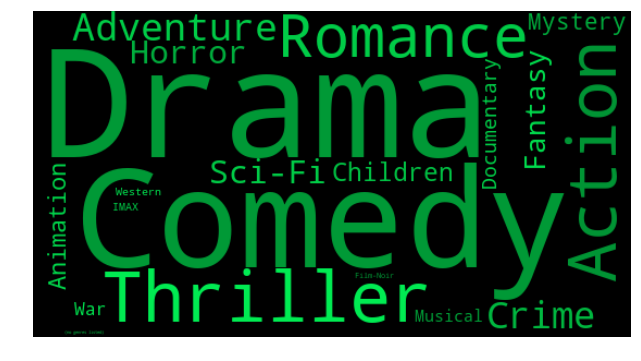

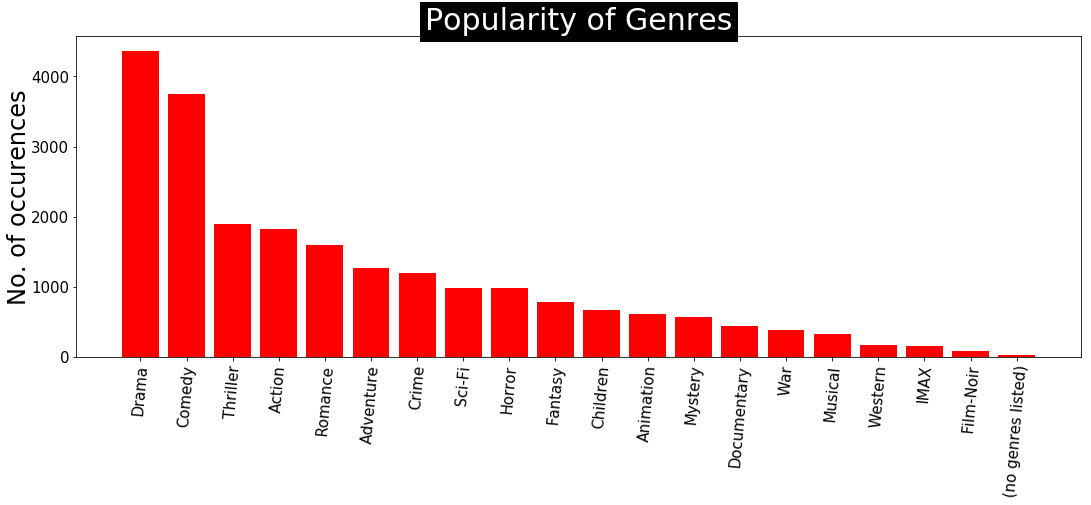